In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://rmoklesur.medium.com/temperature-scaling-fine-tuning-deep-learning-models-for-improved-calibration-730f306e6854

In [ ]:
!pip install transformers
!pip install Keras-Preprocessing
!pip install -U scikit-learn
import textwrap
import keras
import random
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from transformers import AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification
import progressbar
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 46.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
model_type = 'LSGBERT'
n_toks = 2560
df = pd.read_csv('/content/drive/MyDrive/Thesis/train_data/ILDC_multi.csv')

df_train = df.query(" split=='train' ")
df_test = df.query(" split=='test' ")
df_dev = df.query(" split=='dev' ")

In [ ]:
output_dir = '/content/drive/MyDrive/Thesis/calibration/saved_model_multi_2560'
device = torch.device('cuda')
model = AutoModelForSequenceClassification.from_pretrained(output_dir, output_hidden_states=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model.to(device)

LSGBertForSequenceClassification(
  (bert): LSGBertModel(
    (embeddings): LSGBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (global_embeddings): Embedding(512, 768)
    )
    (encoder): LSGBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x LSGBertLayer(
          (attention): LSGAttention(
            (self): LSGSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (attention): LSGAttentionProduct(
                (attention): BaseAttentionProduct(
                  (drop

In [ ]:
def att_masking(input_ids):
  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
  return attention_masks

def input_id_maker(dataf, tokenizer, n_toks):
  input_ids = []
  lengths = []

  for i in progressbar.progressbar(range(len(dataf['text']))):
    sen = dataf['text'].iloc[i] #  select document i

    #------------------FUNCTION CHECK MAX SUPPORTED LENGHT----------------

    #sen_check = sen.split()
    #if len(sen_check) > 10000: # max lenght supported by this tokenizer (16384)
    #  sen = sen_check[len(sen_check)-10000:] # we consider the last 10k tokens of each document
    #  sen = " ".join(sen) # we join the last 10k tokens to retrieve the old sentence

    #----------------------------------------------------------------------

    sen = tokenizer.tokenize(sen) # tokenize the document
    CLS = tokenizer.cls_token # CLS ='[CLS]'
    SEP = tokenizer.sep_token #SEP = '[SEP]'
    if(len(sen) > (n_toks-2)): # if the lenght of sen is > 510 then consider the last 510 tokens
      sen = sen[len(sen)-(n_toks-2):]

    sen = [CLS] + sen + [SEP] # add [CLS] and [SEP]
    encoded_sent = tokenizer.convert_tokens_to_ids(sen) # convert the sen to ids
    input_ids.append(encoded_sent)
    lengths.append(len(encoded_sent))

  input_ids = pad_sequences(input_ids, maxlen=n_toks, value=0, dtype="long", truncating="post", padding="post")

  # truncating = remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.

  return input_ids, lengths

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1


# https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d#:~:text=Definition,into%20M%20equally%20spaced%20bins.

def expected_calibration_error(samples, true_labels, M=10):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

   # keep confidences / predicted "probabilities" as they are
    confidences = samples
    # get binary class predictions from confidences
    predicted_label = (samples>0.5).astype(float)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prop_in_bin = in_bin.astype(float).mean()

        if prop_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

In [ ]:
validation_input_ids, validation_lengths = input_id_maker(df_dev, tokenizer, n_toks)
validation_attention_masks = att_masking(validation_input_ids)
validation_labels = df_dev['label'].to_numpy().astype('int')
validation_inputs = validation_input_ids
validation_masks = validation_attention_masks
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

#use batch size < 6 as it is the upper limit due to our max input length as 512 toks
batch_size = 6
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size = batch_size)

  0% (0 of 994) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--Token indices sequence length is longer than the specified maximum sequence length for this model (7726 > 4096). Running this sequence through the model will result in indexing errors
100% (994 of 994) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


Finding best value of Temperature
Predicting labels for validation sentences with TEMPERATURE = 0.1
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


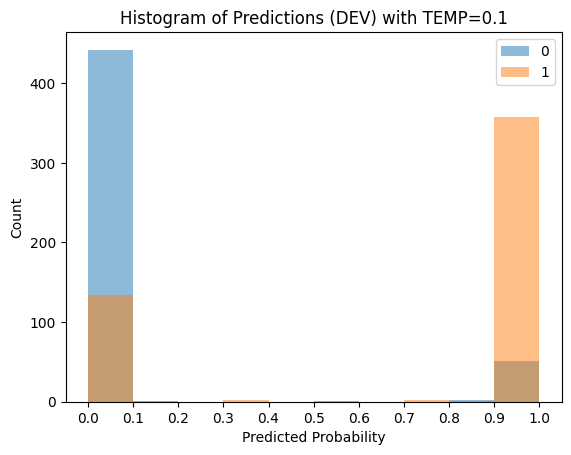

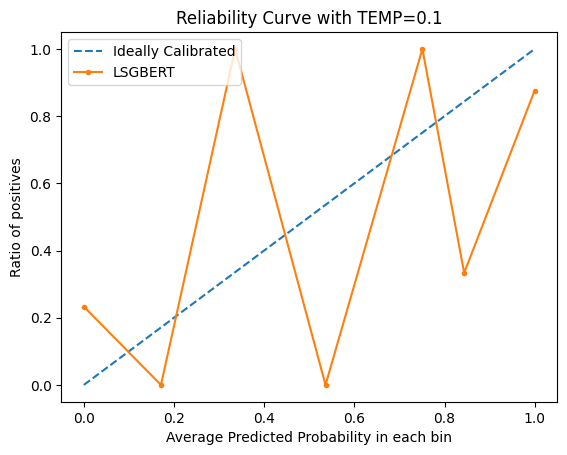

Brier Score Loss: 0.1886072756219647
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.49969101]
Predicting labels for validation sentences with TEMPERATURE = 0.5
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


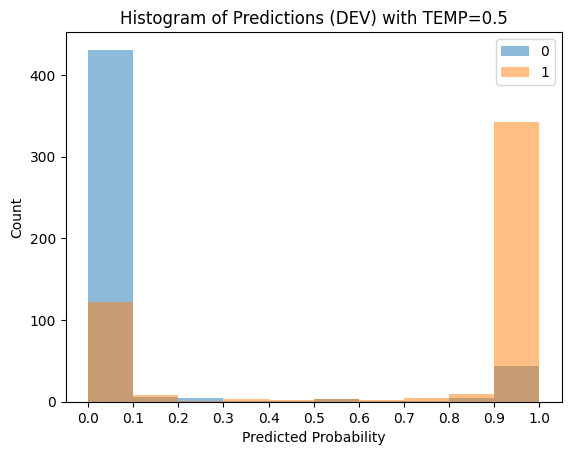

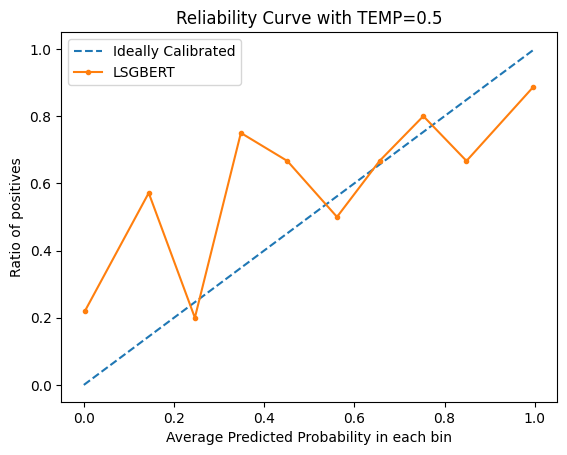

Brier Score Loss: 0.18081310113145047
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.48582924]
Predicting labels for validation sentences with TEMPERATURE = 2
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


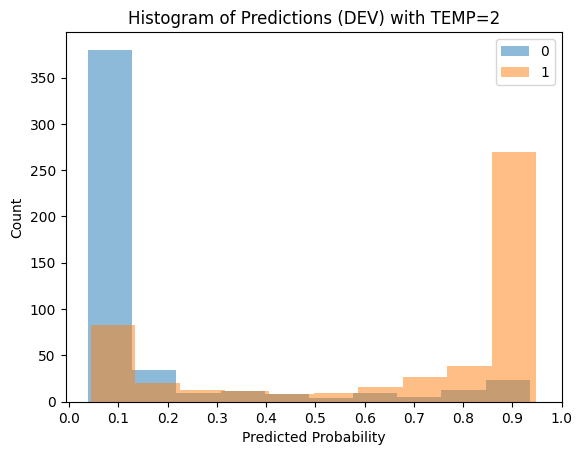

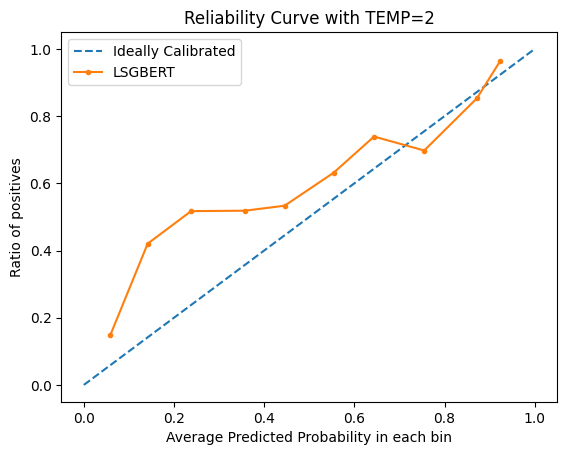

Brier Score Loss: 0.14825250608811882
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.40137595]
Predicting labels for validation sentences with TEMPERATURE = 4
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


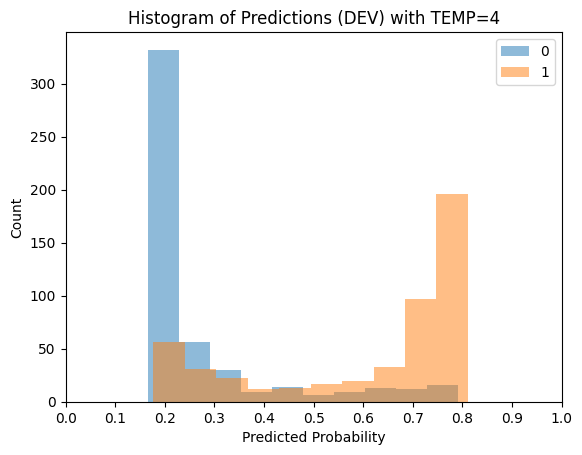

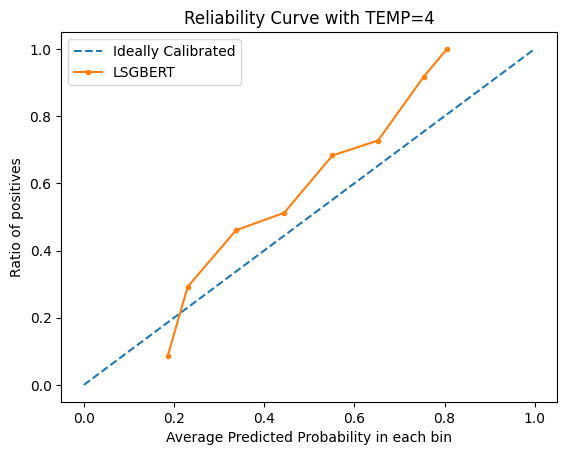

Brier Score Loss: 0.14729383787494232
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.36926073]
Predicting labels for validation sentences with TEMPERATURE = 5
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


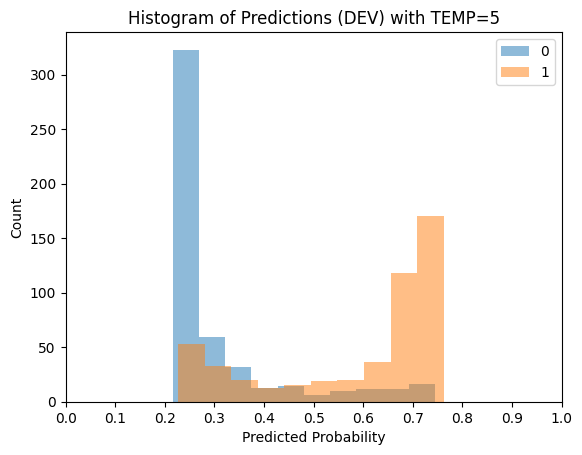

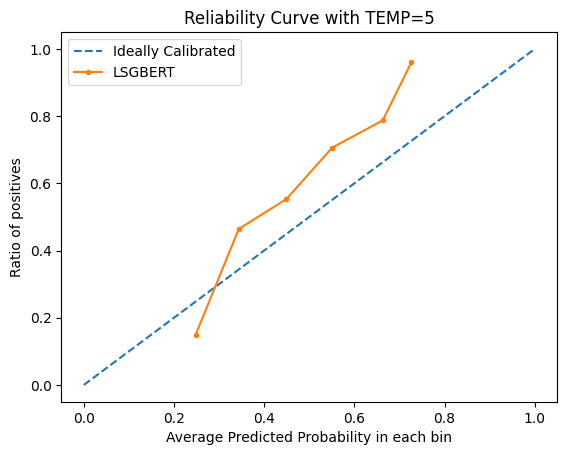

Brier Score Loss: 0.15497587665946544
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.36055635]
Predicting labels for validation sentences with TEMPERATURE = 6
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


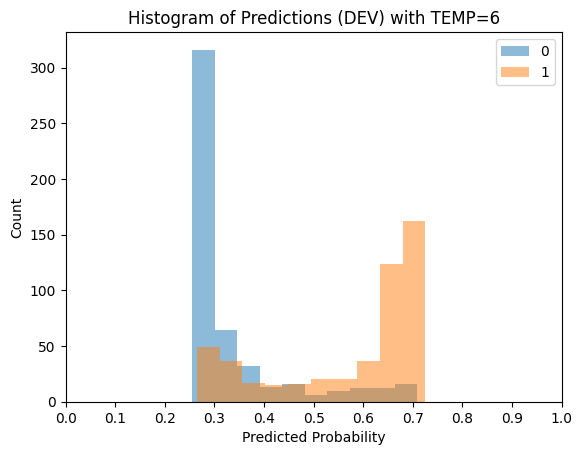

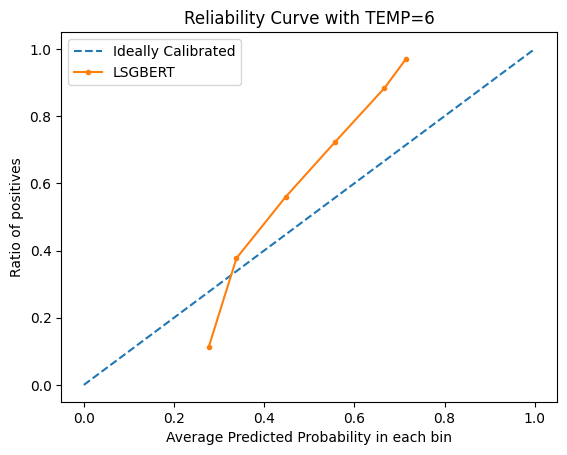

Brier Score Loss: 0.16301245662242397
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.35413693]
Predicting labels for validation sentences with TEMPERATURE = 8
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


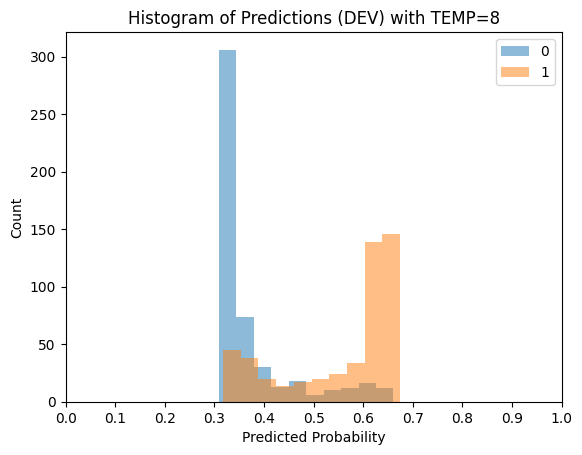

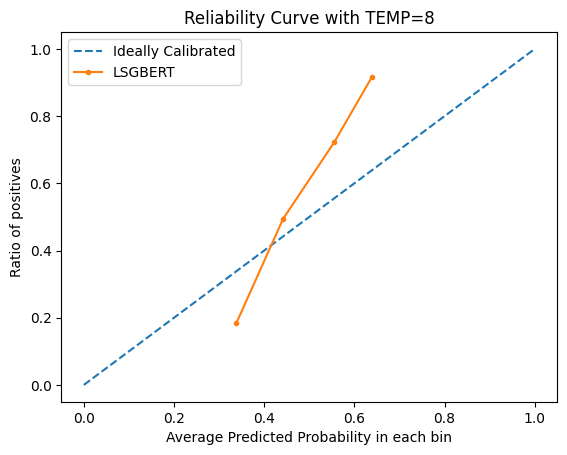

Brier Score Loss: 0.17703078401757072
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.34349949]
Predicting labels for validation sentences with TEMPERATURE = 10
    DONE.
PREDICTIONS ON VALIDATION SET
Accuracy: 0.8088531187122736
macro_precision: 0.817495890296939
macro_recall: 0.8088531187122736
macro_f1: 0.8131515397226773
micro_precision: 0.8088531187122736
micro_recall: 0.8088531187122736
micro_f1: 0.8088531187122735


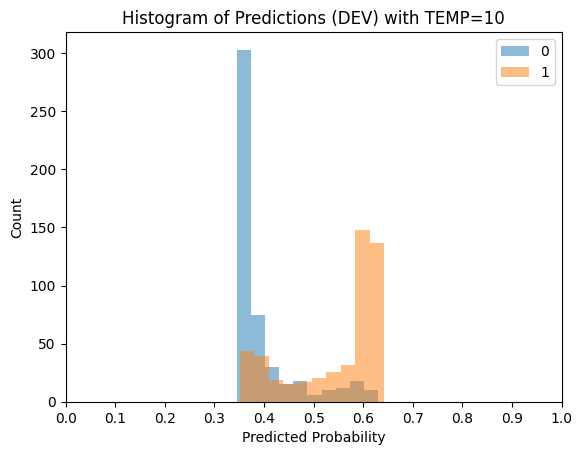

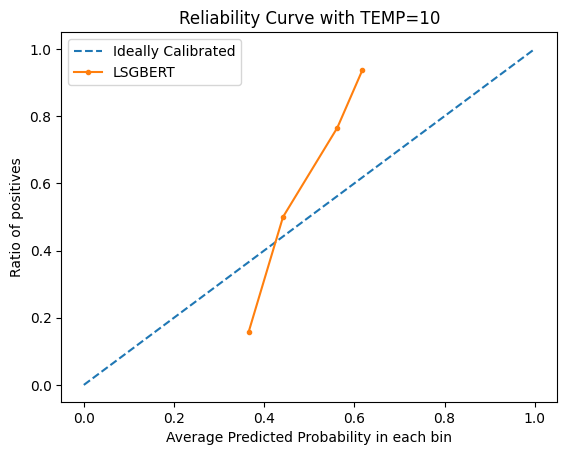

Brier Score Loss: 0.18780835930552908
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.33707785]


In [ ]:
print('Finding best value of Temperature')
model.eval()
temperatures = [0.1, 0.5, 2, 4, 5, 6, 8, 10]
for temp in temperatures:
  predictions, true_labels = [], []
  print(f'Predicting labels for validation sentences with TEMPERATURE = {temp}')
  for (step, batch) in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
          outputs = model(b_input_ids, attention_mask=b_input_mask)

      logits = outputs[0]

      # Apply temperature scaling
      calibrated_logits = logits / temp
      calibrated_probs = torch.softmax(calibrated_logits, dim=1)

      # Move calibrated logits and labels to CPU
      calibrated_probs = calibrated_probs.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(calibrated_probs)
      true_labels.append(label_ids)

  print('    DONE.')

  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)
  pred_flat = np.argmax(predictions, axis=1).flatten()
  labels_flat = true_labels.flatten()

  f_accuracy = flat_accuracy(predictions, true_labels)

  print('PREDICTIONS ON VALIDATION SET')
  print('Accuracy:', f_accuracy)
  macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1 = metrics_calculator(pred_flat, labels_flat)
  print('macro_precision:', macro_precision)
  print('macro_recall:', macro_recall)
  print('macro_f1:', macro_f1)
  print('micro_precision:', micro_precision)
  print('micro_recall:', micro_recall)
  print('micro_f1:', micro_f1)

  pred_1 = predictions[:, 1]

  data_val = {
    "Val_labels": labels_flat,
    "Val_preds": pred_1
   }

  val_preds = pd.DataFrame(data_val)


  # Istogramma delle predizioni
  orange = '#FF8C00'
  bins = np.arange(0, 1.1, step=0.1)
  plt.hist(val_preds.loc[val_preds['Val_labels'] == 0, 'Val_preds'], bins=10, alpha=0.5, label='0')
  plt.hist(val_preds.loc[val_preds['Val_labels'] == 1, 'Val_preds'], bins=10, alpha=0.5, label='1')
  plt.xticks(bins)
  plt.xlabel('Predicted Probability')
  plt.ylabel('Count')
  plt.legend()
  title = 'Histogram of Predictions (DEV) with TEMP='+str(temp)
  plt.title(title)
  name = 'histogram_lsgbert_'+str(temp)
  plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.eps', format='eps', bbox_inches='tight')
  plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.png', format='png', bbox_inches='tight')

  plt.show()

  # Calibration curve
  x, y = calibration_curve(labels_flat, pred_1, n_bins = 10)

  # Plot calibration curve
  # Plot perfectly calibrated
  plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
  # VEDI QUESTO https://www.kaggle.com/code/residentmario/notes-on-classification-probability-calibration
  # Plot model's calibration curve
  plt.plot(y, x, marker = '.', label = 'LSGBERT')

  leg = plt.legend(loc = 'upper left')
  plt.xlabel('Average Predicted Probability in each bin')
  plt.ylabel('Ratio of positives')
  title = 'Reliability Curve with TEMP='+str(temp)
  plt.title(title)

  name = 'cal_curve_lsgbert_'+str(temp)
  plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.eps', format='eps', bbox_inches='tight')
  plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.png', format='png', bbox_inches='tight')
  plt.show()

  # Calculate the Brier Score Loss
  brier_loss = brier_score_loss(labels_flat, pred_1)
  print('Brier Score Loss:', brier_loss)

  ece = expected_calibration_error(pred_1, labels_flat)
  print(f'THE EXPECTED CALIBRATION ERROR IS EQUAL TO {ece}')


In [ ]:
best_temp = 5
print(f' The best value of Temperature is {best_temp}')

 The best value of Temperature is 5


In [ ]:
################ PREDICTIONS ON TEST ###################

labels = df_test.label.to_numpy().astype(int)

input_ids, input_lengths = input_id_maker(df_test, tokenizer, n_toks)
attention_masks = att_masking(input_ids)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 6

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
model.eval()

predictions , true_labels, pred_1 = [], [], []

for (step, batch) in enumerate(prediction_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, attention_mask=b_input_mask)

  logits = outputs[0]

  # Apply temperature scaling
  calibrated_logits = logits / best_temp
  calibrated_probs = torch.softmax(calibrated_logits, dim=1)

  # Move calibrated logits and labels to CPU
  calibrated_probs = calibrated_probs.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(calibrated_probs)
  true_labels.append(label_ids)

print('    DONE.')

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_labels.flatten()

f_accuracy = flat_accuracy(predictions,true_labels)

print('PREDICTIONS ON TEST SET')
print('Accuracy:')
print(f_accuracy)
macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1 = metrics_calculator(pred_flat, labels_flat)
print('macro_precision:', macro_precision)
print('macro_recall:', macro_recall)
print('macro_f1:', macro_f1)
print('micro_precision:', micro_precision)
print('micro_recall:', micro_recall)
print('micro_f1:', micro_f1)

100% (1517 of 1517) |####################| Elapsed Time: 0:01:01 Time:  0:01:01


Predicting labels for 1,517 test sentences...
    DONE.
PREDICTIONS ON TEST SET
Accuracy:
0.8193803559657218
macro_precision: 0.8207271965943193
macro_recall: 0.8195286019711112
macro_f1: 0.820127461354353
micro_precision: 0.8193803559657218
micro_recall: 0.8193803559657218
micro_f1: 0.8193803559657218


In [ ]:
test_preds = pd.read_csv('/content/drive/MyDrive/Thesis/calibration/test_preds_lsgbert2560.csv')

In [ ]:
test_preds

,Test_labels,Test_pred,svc_sigmoid,svc_isotonic,lr_sigmoid,lr_isotonic,calib_temp_5
0,1,0.924973,0.856335,0.884772,0.869168,0.760001,0.623019
1,0,0.001815,0.209630,0.058312,0.210917,0.000000,0.220628
2,0,0.043582,0.236822,0.449392,0.236335,0.454695,0.350302
3,0,0.660483,0.851246,0.911588,0.729759,0.611794,0.533223
4,1,0.986732,0.855963,0.884772,0.890999,0.923423,0.703039
...,...,...,...,...,...,...,...
1512,1,0.253338,0.535351,0.588202,0.393569,0.556424,0.446165
1513,0,0.003745,0.210600,0.141212,0.212045,0.170877,0.246619
1514,1,0.964021,0.856184,0.885253,0.883381,0.795139,0.658729
1515,1,0.857068,0.856308,0.822436,0.840836,0.760001,0.588612


In [ ]:
pred_1 = predictions[:, 1]
column = 'calib_temp_new_'+str(best_temp)
test_preds[column] = pred_1

In [ ]:
test_preds

,Test_labels,Test_pred,svc_sigmoid,svc_isotonic,lr_sigmoid,lr_isotonic,calib_temp_5,calib_temp_new_5
0,1,0.924973,0.856335,0.884772,0.869168,0.760001,0.623019,0.623019
1,0,0.001815,0.209630,0.058312,0.210917,0.000000,0.220628,0.220628
2,0,0.043582,0.236822,0.449392,0.236335,0.454695,0.350302,0.350302
3,0,0.660483,0.851246,0.911588,0.729759,0.611794,0.533223,0.533223
4,1,0.986732,0.855963,0.884772,0.890999,0.923423,0.703039,0.703039
...,...,...,...,...,...,...,...,...
1512,1,0.253338,0.535351,0.588202,0.393569,0.556424,0.446165,0.446165
1513,0,0.003745,0.210600,0.141212,0.212045,0.170877,0.246619,0.246619
1514,1,0.964021,0.856184,0.885253,0.883381,0.795139,0.658729,0.658728
1515,1,0.857068,0.856308,0.822436,0.840836,0.760001,0.588612,0.588612


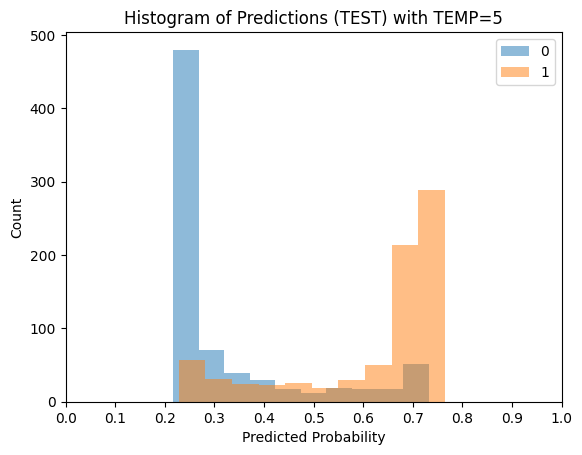

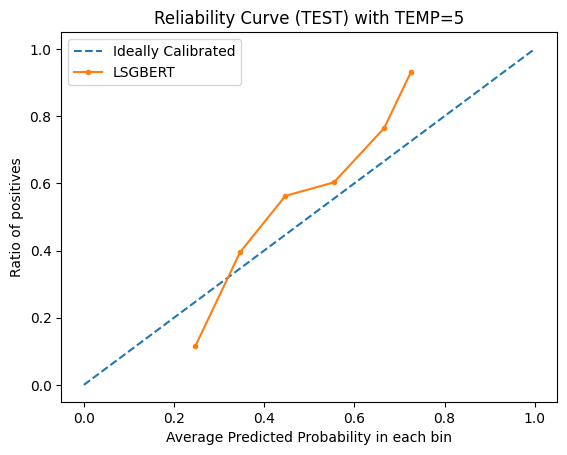

Brier Score Loss: 0.14742692925148576
THE EXPECTED CALIBRATION ERROR IS EQUAL TO [0.34775963]


In [ ]:

# Istogramma delle predizioni
orange = '#FF8C00'
bins = np.arange(0, 1.1, step=0.1)
plt.hist(test_preds.loc[test_preds['Test_labels'] == 0, column], bins=10, alpha=0.5, label='0')
plt.hist(test_preds.loc[test_preds['Test_labels'] == 1, column], bins=10, alpha=0.5, label='1')
plt.xticks(bins)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
title = 'Histogram of Predictions (TEST) with TEMP='+str(best_temp)
plt.title(title)

name = 'histogram_test_lsgbert_'+str(best_temp)
plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.eps', format='eps', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.png', format='png', bbox_inches='tight')
plt.show()

# Calibration curve
x, y = calibration_curve(labels_flat, pred_1, n_bins = 10)

# Plot calibration curve
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
# VEDI QUESTO https://www.kaggle.com/code/residentmario/notes-on-classification-probability-calibration
# Plot model's calibration curve
plt.plot(y, x, marker = '.', label = 'LSGBERT')

leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
title = 'Reliability Curve (TEST) with TEMP='+str(best_temp)
plt.title(title)

name = 'cal_curve_test_lsgbert_'+str(best_temp)
plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.eps', format='eps', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Thesis/calibration/images/'+name+'.png', format='png', bbox_inches='tight')
plt.show()

# Calculate the Brier Score Loss
brier_loss = brier_score_loss(labels_flat, pred_1)
print('Brier Score Loss:', brier_loss)

ece = expected_calibration_error(pred_1, labels_flat)
print(f'THE EXPECTED CALIBRATION ERROR IS EQUAL TO {ece}')

In [ ]:
test_preds.to_csv('/content/drive/MyDrive/Thesis/calibration/test_preds_lsgbert2560.csv', index=False)